<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Convolutional Neural Networks and Computer Vision with TensorFlow
This notebook will cover the following with TensorFlow:
* Getting a dataset to work with.
* Architecture of convolutional neural network
* A quick end-to-end example
* Steps in modelling for binary image classifications with CNNs
  * Becoming one with data
  * Preparing the data for modelling.
  * Creating a CNN model ( starting with baseline )
  * Evaluating a model
  * Improving a model
  * Making a prediction with trained model
* Steps in modelling for multi-class image classification with CNNs
  * Same as above but with a multi-class dataset



## Get the data
The images we will be using are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 real world images of food dishes.

In [1]:
import zipfile
# Downlad the zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

#unzip the zip file
zip_ref = zipfile.ZipFile('pizza_steak.zip','r')
zip_ref.extractall()
zip_ref.close()

--2023-07-09 08:52:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   204MB/s    in 0.5s    

2023-07-09 08:52:50 (204 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



Inspect the data [Becoming one with data](https://karpathy.github.io/2019/04/25/recipe/)

In [2]:
# File structure
!ls pizza_steak

test  train


In [3]:
!pip install tree

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.1 MB/s eta 0:00:00
  Created wheel for tree: filename=Tree-0.2.4-py3-none-any.whl size=7859 sha256=6c11714b6a27aa1a82450900f18d29175b4ffb79192704d9e185da1e228b9f10
  Stored in directory: /root/.cache/pip/wheels/06/1e/8c/73b3a97f37991dc90603631567511071513ee3c6d819393232
Successfully built tree


In [4]:
import os
for dirpath, dirnames,filenames in os.walk("pizza_steak"):
  print(f" There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

 There are 2 directories and 0 images in pizza_steak
 There are 2 directories and 0 images in pizza_steak/train
 There are 0 directories and 750 images in pizza_steak/train/pizza
 There are 0 directories and 750 images in pizza_steak/train/steak
 There are 2 directories and 0 images in pizza_steak/test
 There are 0 directories and 250 images in pizza_steak/test/pizza
 There are 0 directories and 250 images in pizza_steak/test/steak


In [5]:
# Get the class names
## the class names are the name of the folders containing respective images.

import pathlib
import numpy as np

def get_classnames(train_dir: str) -> list[str]:

  """
    This function will return the name of the folers in training directory.
    Args:
      train_dir(str): The name of train directory

    Returns:
      directory_names(list[str]): The name of the directories in the train_dir directory.
  """
  data_dir = pathlib.Path(train_dir)
  folder_names = sorted([item.name for item in data_dir.glob("*")])
  return folder_names


In [6]:
classnames = get_classnames("pizza_steak/train")
classnames

['pizza', 'steak']

> 🔑note: Whenever working with data, it's always good to visualize as much as possible. The first few steps of any project is becoming one with data. **Visualize**, **visualize**, **visualize**

Let's write a function to plot a random image and its shape

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# function to view a random image from given a target directory and a target class

def view_random_image(target_dir,target_class):
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  print(f" Showing image {random_image[0]} from {target_folder}")
  print(f" Shape of the image {img.shape}")
  plt.title(target_class)
  plt.axis("off")
  return img

 Showing image 1098197.jpg from pizza_steak/train/pizza
 Shape of the image (384, 512, 3)


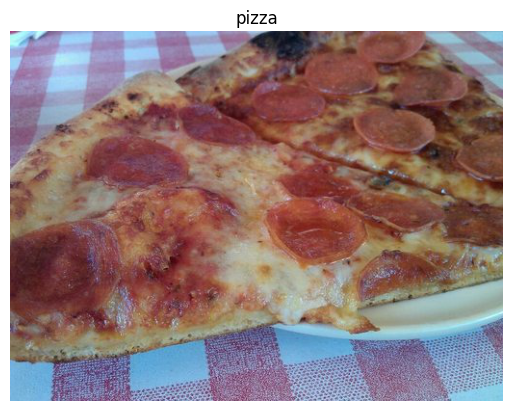

In [8]:
img = view_random_image("pizza_steak/train/","pizza")

In [9]:
img.max(),img.min()

(255, 0)

In [10]:
img/255

array([[[0.65882353, 0.24705882, 0.50980392],
        [0.66666667, 0.27058824, 0.52941176],
        [0.66666667, 0.29803922, 0.54117647],
        ...,
        [0.52941176, 0.74901961, 0.84705882],
        [0.50588235, 0.7254902 , 0.82352941],
        [0.48235294, 0.70196078, 0.8       ]],

       [[0.61176471, 0.30196078, 0.5254902 ],
        [0.61960784, 0.3254902 , 0.54509804],
        [0.62745098, 0.35686275, 0.56862745],
        ...,
        [0.55686275, 0.78431373, 0.87843137],
        [0.55686275, 0.77647059, 0.88235294],
        [0.54509804, 0.76470588, 0.87058824]],

       [[0.59607843, 0.45882353, 0.61568627],
        [0.61568627, 0.49019608, 0.64313725],
        [0.63529412, 0.53333333, 0.67843137],
        ...,
        [0.56078431, 0.79607843, 0.89803922],
        [0.56470588, 0.8       , 0.90196078],
        [0.56470588, 0.8       , 0.90196078]],

       ...,

       [[0.45098039, 0.69019608, 0.8627451 ],
        [0.45882353, 0.70196078, 0.8627451 ],
        [0.46666667, 0

# An end-to-end example

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set seed
tf.random.set_seed(42)

# Preprocess data ( get all the pixel values of a image within 0,1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up the train and test directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# import data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir
                                               ,batch_size=32
                                               ,target_size=(224,224)
                                               ,class_mode="binary"
                                               ,seed=42)
valid_data = valid_datagen.flow_from_directory(test_dir
                                               ,batch_size=32
                                               ,target_size=(224,224)
                                               ,class_mode="binary"
                                               ,seed=42)

# Create an CNN (TinyVGG) model same as https://poloclub.github.io/cnn-explainer/

model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=(3,3)
                           ,activation="relu"
                           ,input_shape=(224,224,3))
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.MaxPool2D(pool_size=2
                               ,padding="valid")
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.MaxPool2D(2)
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# Fit the model with train & valid data
history_1 = model_1.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=valid_data
                        ,validation_steps=len(valid_data)
                        ,epochs=5
#                        ,verbose=0
                        )


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 31s 260ms/step - loss: 0.5762 - accuracy: 0.6893 - val_loss: 0.4394 - val_accuracy: 0.7920
Epoch 2/5
47/47 [==============================] - 11s 239ms/step - loss: 0.4209 - accuracy: 0.8160 - val_loss: 0.3486 - val_accuracy: 0.8440
Epoch 3/5
47/47 [==============================] - 11s 240ms/step - loss: 0.3922 - accuracy: 0.8207 - val_loss: 0.3099 - val_accuracy: 0.8580
Epoch 4/5
47/47 [==============================] - 13s 281ms/step - loss: 0.3579 - accuracy: 0.8447 - val_loss: 0.2954 - val_accuracy: 0.8780
Epoch 5/5
47/47 [==============================] - 12s 260ms/step - loss: 0.3021 - accuracy: 0.8693 - val_loss: 0.2562 - val_accuracy: 0.9040


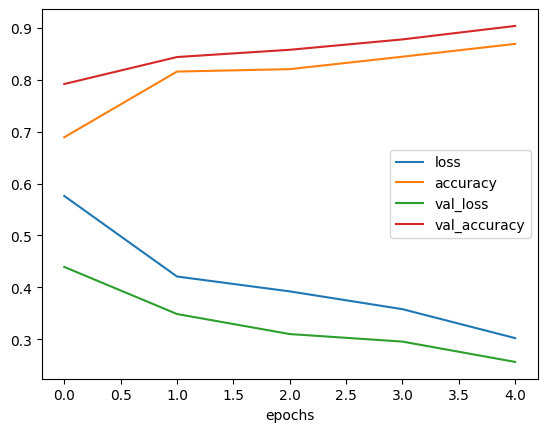

In [12]:
import pandas as pd
pd.DataFrame(history_1.history).plot(xlabel="epochs");

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

Let's try to fit our earlier model from `learn_tf_003` notebook. The model with 4 layers

In [14]:
# set seed
tf.random.set_seed(42)

# build the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3))
    ,tf.keras.layers.Dense(4,activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(4,activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])

# compile the model
model_2.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# Fit the model
history_2 = model_2.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=valid_data
                        ,validation_steps=len(valid_data)
                        ,epochs=5)

Epoch 1/5
47/47 [==============================] - 22s 405ms/step - loss: 0.7771 - accuracy: 0.5413 - val_loss: 0.6650 - val_accuracy: 0.7200
Epoch 2/5
47/47 [==============================] - 15s 312ms/step - loss: 0.6287 - accuracy: 0.6833 - val_loss: 0.5850 - val_accuracy: 0.7520
Epoch 3/5
47/47 [==============================] - 10s 219ms/step - loss: 0.5872 - accuracy: 0.7400 - val_loss: 0.5687 - val_accuracy: 0.7760
Epoch 4/5
47/47 [==============================] - 10s 222ms/step - loss: 0.5765 - accuracy: 0.7473 - val_loss: 0.5882 - val_accuracy: 0.7160
Epoch 5/5
47/47 [==============================] - 10s 221ms/step - loss: 0.5639 - accuracy: 0.7593 - val_loss: 0.5447 - val_accuracy: 0.7840


<Axes: xlabel='epochs'>

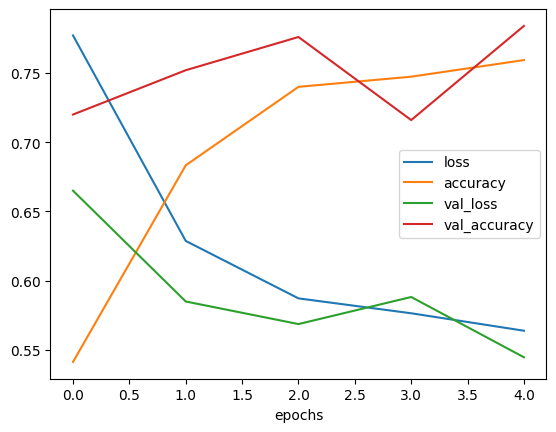

In [15]:
pd.DataFrame(history_2.history).plot(xlabel="epochs")

In [16]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


The last model didn't work . Let's add one more layer and increase the number of neurons( also known as hidden units ) in each dense layer from 4 to 100.

In [17]:
# set random seed
tf.random.set_seed(42)

# build the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3))
    ,tf.keras.layers.Dense(100, activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(100, activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(100, activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# compile the model
model_3.compile(loss= tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_3 = model_3.fit(train_data
            ,epochs=5
            ,steps_per_epoch=len(train_data)
            ,validation_data=valid_data
            ,validation_steps=len(valid_data)
            )

Epoch 1/5
47/47 [==============================] - 12s 226ms/step - loss: 6.1261 - accuracy: 0.6407 - val_loss: 0.7101 - val_accuracy: 0.7520
Epoch 2/5
47/47 [==============================] - 10s 210ms/step - loss: 0.8403 - accuracy: 0.7027 - val_loss: 2.7144 - val_accuracy: 0.5620
Epoch 3/5
47/47 [==============================] - 10s 216ms/step - loss: 1.1749 - accuracy: 0.6700 - val_loss: 0.4398 - val_accuracy: 0.7820
Epoch 4/5
47/47 [==============================] - 12s 266ms/step - loss: 0.5593 - accuracy: 0.7620 - val_loss: 0.4443 - val_accuracy: 0.7900
Epoch 5/5
47/47 [==============================] - 10s 223ms/step - loss: 0.4849 - accuracy: 0.7773 - val_loss: 0.5844 - val_accuracy: 0.7200


In [18]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


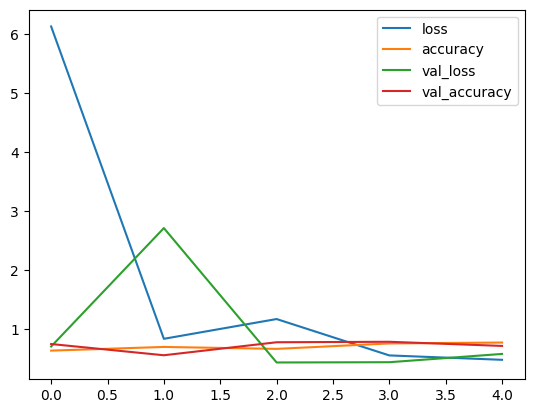

In [19]:
pd.DataFrame(history_3.history).plot();

# Binary Classification

## Step 1 : Be one with Data

 Showing image 2560539.jpg from pizza_steak/train/pizza
 Shape of the image (512, 512, 3)
 Showing image 184226.jpg from pizza_steak/train/steak
 Shape of the image (512, 506, 3)


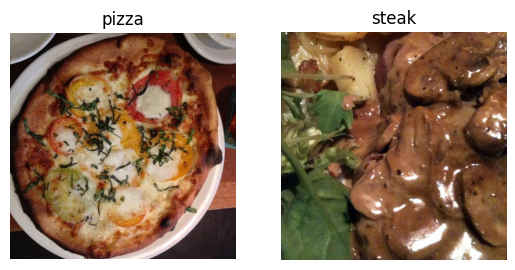

In [20]:
# visualize random images
plt.figure()
plt.subplot(1,2,1)
pizza_img=view_random_image("pizza_steak/train/","pizza")
plt.subplot(1,2,2)
steak_img=view_random_image("pizza_steak/train/","steak")

## Step 2 : Preprocess the data
1. Create the train and test directory paths
2. Create batch: Usually a batch size of 32 works in almost all cases.


In [21]:
#1. Define the train and test directory paths
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"


In [22]:
#2. Create Batch:
# To create batch first we need to create an instance of ImageDataGenerator for each dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from their respective folders using `.flow_from_directory` method of ImageDataGenerator
train_data = train_datagen.flow_from_directory(directory=train_dir
                                                    ,target_size=(224,224)
                                                    ,class_mode="binary"
                                                    ,batch_size=32)
test_data = test_datagen.flow_from_directory(directory=test_dir
                                                   ,target_size=(224,224)
                                                   ,class_mode="binary"
                                                   ,batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [23]:
# ImageDataGenerator is deprecated. Let's give a try of following the suggestion of using tf.keras.utils.image_dataset_from_directory` and transforming the output
# `tf.data.Dataset` with preprocessing layers
train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_dir
                                                            ,image_size=(224,224)
                                                            ,batch_size=32
                                                            ,labels="inferred"
                                                            ,label_mode="binary")

test_dataset = tf.keras.utils.image_dataset_from_directory(directory=test_dir
                                                           ,image_size=(224,224)
                                                           ,batch_size=32
                                                           ,labels="inferred"
                                                           ,label_mode="binary")

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [24]:
images,labels = train_data.next()
len(images), len(labels)

(32, 32)

## Step 3 : Build the model

In [25]:
# set seeds
tf.random.set_seed(42)

# build the model
model_4 =  tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=3
                           ,strides=1
                           ,padding="valid"
                           ,activation="relu"
                           ,input_shape=(224,224,3))
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_4 = model_4.fit(train_data
            ,steps_per_epoch=len(train_data)
            ,validation_data=test_data
            ,validation_steps=len(test_data)
            ,epochs=5)

Epoch 1/5
47/47 [==============================] - 15s 256ms/step - loss: 0.7125 - accuracy: 0.6633 - val_loss: 0.5670 - val_accuracy: 0.7060
Epoch 2/5
47/47 [==============================] - 11s 243ms/step - loss: 0.4692 - accuracy: 0.7973 - val_loss: 0.4722 - val_accuracy: 0.7700
Epoch 3/5
47/47 [==============================] - 11s 240ms/step - loss: 0.3486 - accuracy: 0.8573 - val_loss: 0.3689 - val_accuracy: 0.8260
Epoch 4/5
47/47 [==============================] - 11s 240ms/step - loss: 0.2101 - accuracy: 0.9293 - val_loss: 0.4428 - val_accuracy: 0.8280
Epoch 5/5
47/47 [==============================] - 11s 237ms/step - loss: 0.0841 - accuracy: 0.9800 - val_loss: 0.4339 - val_accuracy: 0.8140


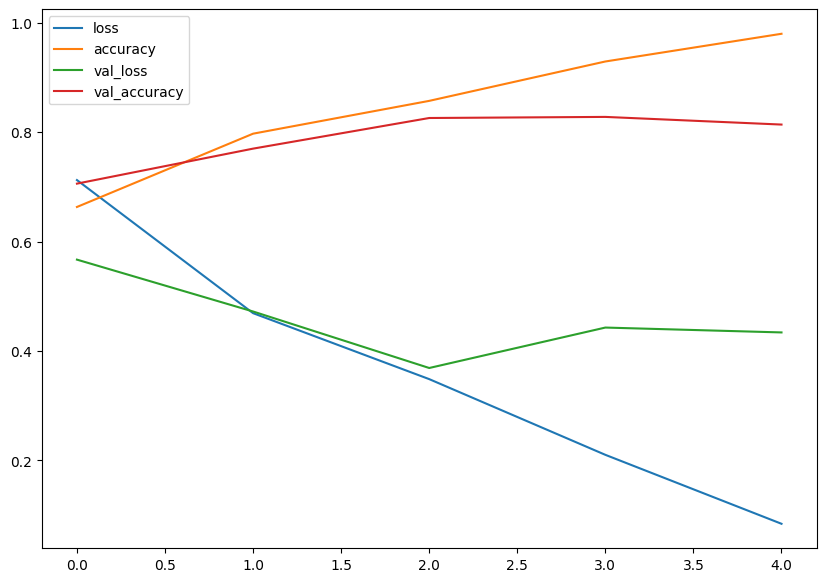

In [26]:
# Plot the loss curve
pd.DataFrame(history_4.history).plot(figsize=(10,7));

In [27]:
print(tf.__version__)

2.12.0


🇹 The current code is using `ImageDataGenerator` to create data for training and validation. We should change it to `tf.keras.utils.image_dataset_from_directory` as suggested in API docs.

Function to separate the loss and accuracy curve.

In [28]:
def plot_loss_curve(history):
  """
    Returns separate loss curves for training and validation metrics
  """

  loss = history["loss"]
  val_loss = history["val_loss"]

  acc=history["accuracy"]
  val_acc = history["val_accuracy"]

  epochs = range(len(history["loss"]))

  # Plot loss
  plt.figure()
  plt.plot(epochs,loss,label="loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,acc,label="accuracy")
  plt.plot(epochs,val_acc,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

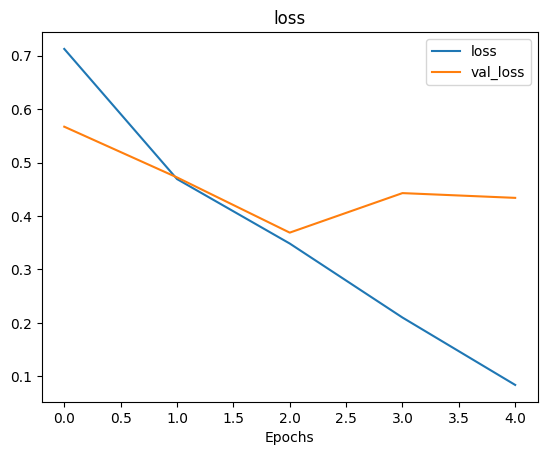

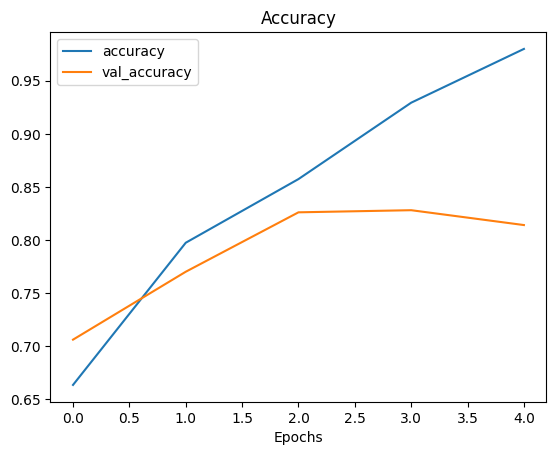

In [29]:
plot_loss_curve(history_4.history)

In [30]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


Let's build 2 more models

* A convnet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A convnet with max pooling and data augmentation

In [31]:
from keras.layers import MaxPool2D
from tensorflow.python.ops.gen_nn_ops import MaxPool
from keras.layers.convolutional.conv2d_transpose import Conv2D
# A model with max pooling

#set seed
tf.random.set_seed(42)

# build the model

model_5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=3
                           ,padding="valid"
                           ,strides=1
                           ,activation="relu"
                           ,input_shape=(224,224,3))
    ,tf.keras.layers.MaxPool2D(pool_size=2)
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model

model_5.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_5 = model_5.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=valid_data
                        ,validation_steps=len(valid_data)
                        ,epochs=5)



Epoch 1/5
47/47 [==============================] - 13s 238ms/step - loss: 0.6088 - accuracy: 0.6707 - val_loss: 0.4753 - val_accuracy: 0.7900
Epoch 2/5
47/47 [==============================] - 11s 226ms/step - loss: 0.4660 - accuracy: 0.7987 - val_loss: 0.3987 - val_accuracy: 0.8260
Epoch 3/5
47/47 [==============================] - 13s 267ms/step - loss: 0.4261 - accuracy: 0.8153 - val_loss: 0.3856 - val_accuracy: 0.8440
Epoch 4/5
47/47 [==============================] - 11s 225ms/step - loss: 0.4047 - accuracy: 0.8320 - val_loss: 0.3967 - val_accuracy: 0.8240
Epoch 5/5
47/47 [==============================] - 10s 206ms/step - loss: 0.3647 - accuracy: 0.8507 - val_loss: 0.3623 - val_accuracy: 0.8320


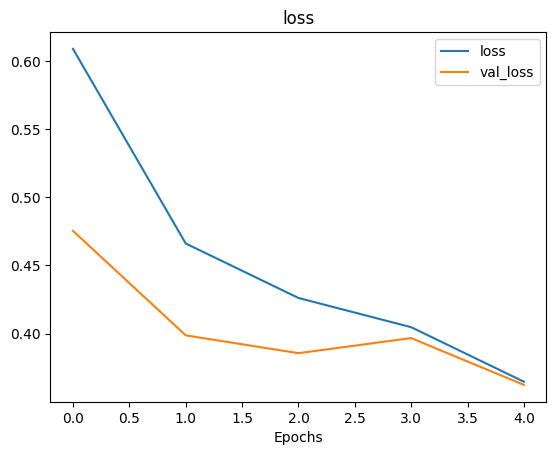

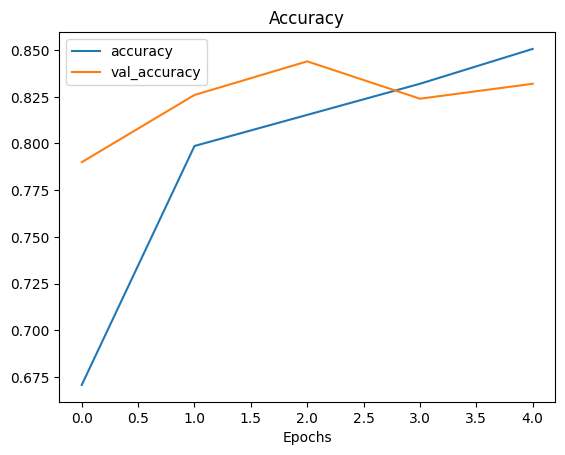

In [32]:
plot_loss_curve(history_5.history)

In [33]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

#### Perform Data augmentation

In [34]:
# Create ImageDataGenerator instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1./255
                                          ,rotation_range=20
                                          ,shear_range=0.2
                                          ,zoom_range=0.2
                                          ,width_shift_range=0.2
                                          ,height_shift_range=0.2
                                          ,horizontal_flip=True)

# Create ImageDataGenerator instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Create ImageDataGenerator instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [35]:
print(f"Augmented training data")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir
                                                                ,target_size=(224,224)
                                                                ,batch_size=32
                                                                ,class_mode="binary"
                                                                ,shuffle=False)

print(f"Non-Augmented training data")
train_data = train_datagen.flow_from_directory(train_dir
                                               ,target_size=(224,224)
                                               ,batch_size=32
                                               ,class_mode="binary"
                                               ,shuffle=False)

print(f"Non-Augmented test data")
test_data = test_datagen.flow_from_directory(test_dir
                                             ,target_size=(224,224)
                                             ,batch_size=32
                                             ,class_mode="binary"
                                            )

Augmented training data
Found 1500 images belonging to 2 classes.
Non-Augmented training data
Found 1500 images belonging to 2 classes.
Non-Augmented test data
Found 500 images belonging to 2 classes.


In [36]:
images,labels= train_data.next()
augmented_images,augmented_labels=train_data_augmented.next()

 Random number : 20


(-0.5, 223.5, 223.5, -0.5)

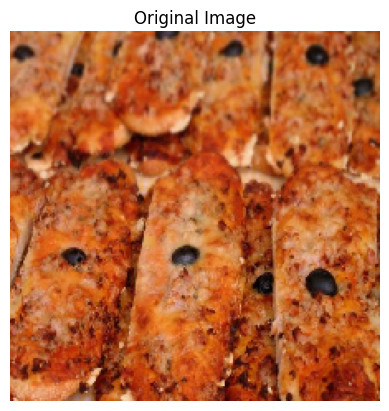

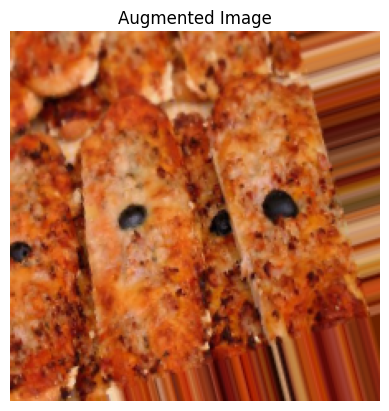

In [37]:
#show a random image
random_number = random.randint(0,32)
print(f" Random number : {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original Image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented Image")
plt.axis(False)

In [38]:
# set seeds
tf.random.set_seed(42)

# build the model
model_6 = tf.keras.Sequential([
    Conv2D(10,3,activation="relu",input_shape=(224,224,3))
    ,MaxPool2D(pool_size=2)
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_6 = model_6.fit(train_data_augmented
            ,steps_per_epoch=len(train_data_augmented)
            ,validation_data=test_data
            ,validation_steps=len(test_data)
            ,epochs=5)


Epoch 1/5
47/47 [==============================] - 27s 541ms/step - loss: 0.7037 - accuracy: 0.4840 - val_loss: 0.6899 - val_accuracy: 0.6820
Epoch 2/5
47/47 [==============================] - 26s 560ms/step - loss: 0.6930 - accuracy: 0.5687 - val_loss: 0.6754 - val_accuracy: 0.6980
Epoch 3/5
47/47 [==============================] - 25s 542ms/step - loss: 0.6777 - accuracy: 0.6347 - val_loss: 0.6840 - val_accuracy: 0.5600
Epoch 4/5
47/47 [==============================] - 25s 541ms/step - loss: 0.6580 - accuracy: 0.6287 - val_loss: 0.4986 - val_accuracy: 0.8080
Epoch 5/5
47/47 [==============================] - 25s 543ms/step - loss: 0.6538 - accuracy: 0.6020 - val_loss: 0.5330 - val_accuracy: 0.7400


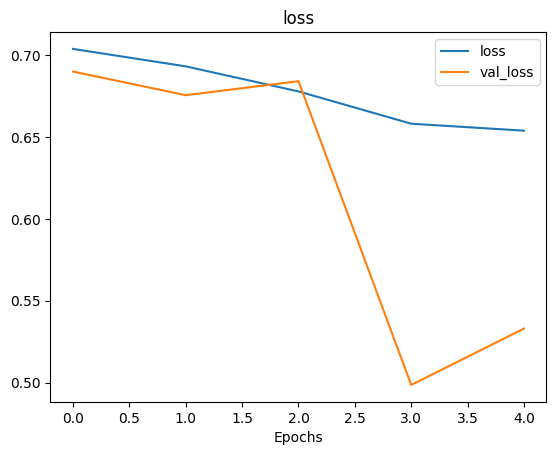

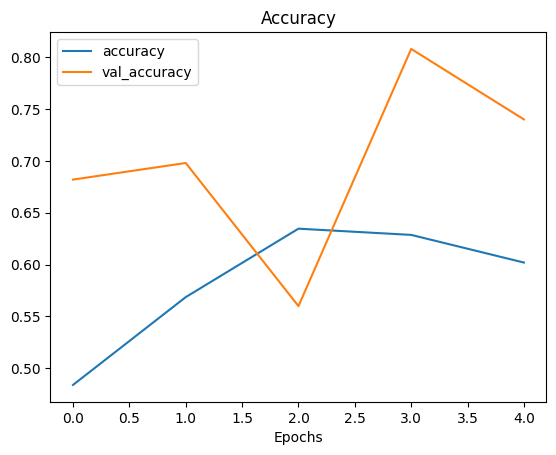

In [39]:
plot_loss_curve(history_6.history)

🤔 Why didn't the model get very good results on the training set to begin with ❔

It's because when we created `train_data_augmented`, we didn't disabled shuffle using `shuffle=False` which means our model only sees a batch of single kind of images at a time.

For example, the pizza class gets loaded first because it's the first class.Thus it's performance is measured on only a single class rather than both classes.The validation data performance improves steadily becuase it contains shuffled data.

The `ImageDataGenerator` augments the data as it's loaded to the model. The _benefit_ is that it leaves the original image unchanged but the _downside_ of the approach is that it takes longer to load the images.

The above is behaviour can be observed from the increase in time for each epoch from ~13sec to ~26sec

Let's now shuffle the augmented data and check the model performance on training and validation data.

In [40]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir
                                                                            ,class_mode="binary"
                                                                            ,target_size=(224,224)
                                                                            ,batch_size=32
                                                                            ,shuffle=True)

Found 1500 images belonging to 2 classes.


In [41]:
# build the model

# set seeds
tf.random.set_seed(42)

# build the model
model_7 = tf.keras.Sequential([
    Conv2D(10,3,activation="relu",input_shape=(224,224,3))
    ,MaxPool2D(pool_size=2)
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy
              ,optimizer=tf.keras.optimizers.Adam()
              ,metrics=["accuracy"]
              )

# fit the model
history_7 = model_7.fit(train_data_augmented_shuffled
                        ,steps_per_epoch=len(train_data_augmented_shuffled)
                        ,validation_data=test_data
                        ,validation_steps=len(test_data)
                        ,epochs=5)

Epoch 1/5
47/47 [==============================] - 27s 538ms/step - loss: 0.6761 - accuracy: 0.5800 - val_loss: 0.6307 - val_accuracy: 0.6480
Epoch 2/5
47/47 [==============================] - 25s 542ms/step - loss: 0.5832 - accuracy: 0.7080 - val_loss: 0.4367 - val_accuracy: 0.8240
Epoch 3/5
47/47 [==============================] - 26s 561ms/step - loss: 0.5221 - accuracy: 0.7500 - val_loss: 0.3925 - val_accuracy: 0.8520
Epoch 4/5
47/47 [==============================] - 25s 540ms/step - loss: 0.5031 - accuracy: 0.7627 - val_loss: 0.3512 - val_accuracy: 0.8400
Epoch 5/5
47/47 [==============================] - 25s 541ms/step - loss: 0.4679 - accuracy: 0.7713 - val_loss: 0.3640 - val_accuracy: 0.8500


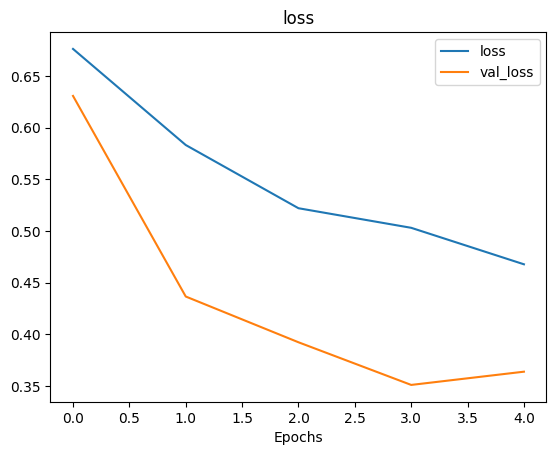

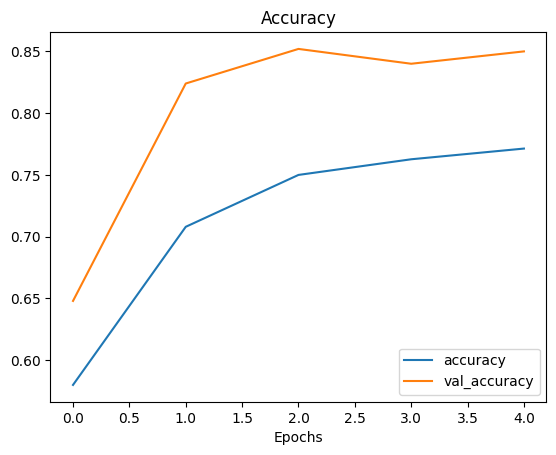

In [42]:
plot_loss_curve(history_7.history)

Make a prediction using the trained model

In [43]:
print(classnames)

['pizza', 'steak']


--2023-07-09 09:04:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.06s   

2023-07-09 09:04:04 (31.5 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



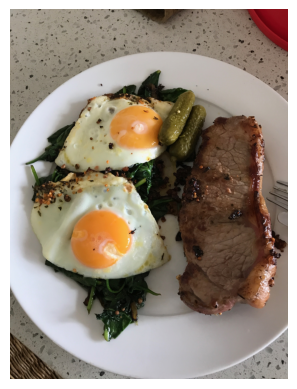

In [44]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [45]:
steak.shape

(4032, 3024, 3)

Our model is trained for image size = (224,224), so we have to resize the steak image to make it suitable for our model.
For this we will have to use `tf.io.read_file` (for reading files) and `tf.image` (for resizing our image and turning it into tensor)

In [46]:
def load_and_prep_image(filename,img_shape=224):
  """
    Reads an image from filename, turn it into tensor
    and reshape it to (img_shape, img_shape, color_channel)
  """

  # Read in target file ( an image )
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 color channels
  img = tf.image.decode_image(img,channels=3)

  # Resize the image
  img = tf.image.resize(img,size=[img_shape,img_shape])

  # Rescale the image
  return img/255.

In [47]:
img_tensor = load_and_prep_image("/content/03-steak.jpeg")
img_tensor.shape

TensorShape([224, 224, 3])

In [48]:
pred_probs = model_7.predict(tf.expand_dims(img_tensor,axis=0))

1/1 [==============================] - 0s 258ms/step


In [49]:
tf.expand_dims(img_tensor,axis=0).shape

TensorShape([1, 224, 224, 3])

In [50]:
predicted_class = classnames[int(tf.round(pred_probs)[0][0])]
predicted_class

'steak'

# Multi-class classification

Steps Involved
1. Become one with data ( visualize, visualize, visualize )
2. Preprocess the data ( prepare it for model )
3. Create a model ( start with baseline )
4. Fit a model
5. Evaluate the model
6. Adjust different parameters and improve the model.
7. Repeat until satisfied.

In [51]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

#unzip the download file
zip_ref = zipfile.ZipFile("/content/10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-09 09:04:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 209.85.234.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   179MB/s    in 2.8s    

2023-07-09 09:04:11 (179 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [52]:
!rm -r /content/__MACOSX

## Be one with data

In [53]:
import os

for dirpath,dirnames,filesnames in os.walk("/content/10_food_classes_all_data"):
  print(f"There are {len(dirnames)} and {len(filenames)} images in {dirpath}")

There are 2 and 250 images in /content/10_food_classes_all_data
There are 10 and 250 images in /content/10_food_classes_all_data/train
There are 0 and 250 images in /content/10_food_classes_all_data/train/ramen
There are 0 and 250 images in /content/10_food_classes_all_data/train/chicken_wings
There are 0 and 250 images in /content/10_food_classes_all_data/train/pizza
There are 0 and 250 images in /content/10_food_classes_all_data/train/grilled_salmon
There are 0 and 250 images in /content/10_food_classes_all_data/train/steak
There are 0 and 250 images in /content/10_food_classes_all_data/train/chicken_curry
There are 0 and 250 images in /content/10_food_classes_all_data/train/ice_cream
There are 0 and 250 images in /content/10_food_classes_all_data/train/sushi
There are 0 and 250 images in /content/10_food_classes_all_data/train/hamburger
There are 0 and 250 images in /content/10_food_classes_all_data/train/fried_rice
There are 10 and 250 images in /content/10_food_classes_all_data/te

In [54]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

classnames_10 = get_classnames(train_dir=train_dir)
classnames_10

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

 Showing image 670788.jpg from 10_food_classes_all_data/train/ice_cream
 Shape of the image (384, 512, 3)


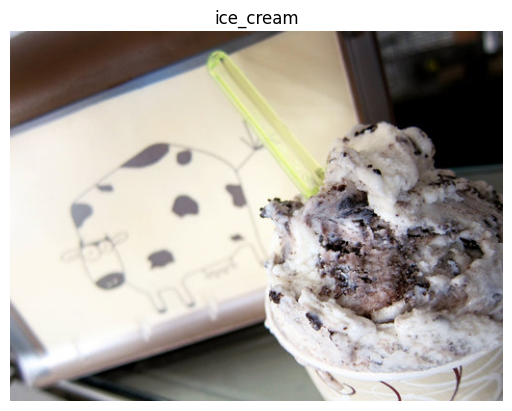

In [55]:
import random
icecream = view_random_image(target_dir=train_dir,target_class="ice_cream")

 Showing image 390178.jpg from 10_food_classes_all_data/train/sushi
 Shape of the image (384, 512, 3)


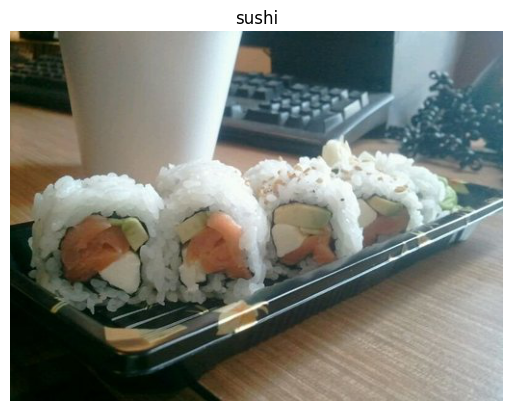

In [56]:
random_train_img = view_random_image(target_dir=train_dir,target_class=random.choice(classnames_10))

 Showing image 3902013.jpg from 10_food_classes_all_data/test/fried_rice
 Shape of the image (512, 512, 3)


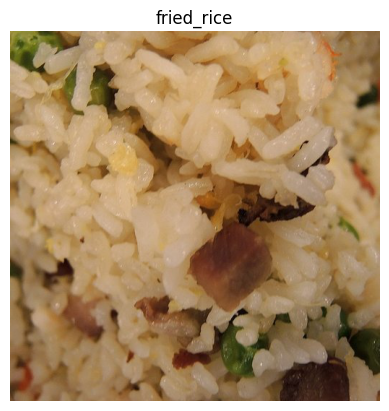

In [57]:
random_test_img = view_random_image(target_dir=test_dir,target_class=random.choice(classnames_10))

## Pre-Process the data

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir
                                               ,class_mode="categorical"
                                               ,batch_size=32
                                               ,target_size=(224,224)
                                               )

test_data = test_datagen.flow_from_directory(test_dir
                                             ,class_mode="categorical"
                                             ,batch_size=32
                                             ,target_size=(224,224)
                                             )


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Create a Baseline model

We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

1. Change the output layers to 10 output neurons
2. Change the output layer to use `softmax` instead of `sigmoid`
3. Change the loss function from `binary_crossentropy` to `categorical_crossentropy`

In [59]:
# set seeds
tf.random.set_seed(42)

# build the model
model_8 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=3
                           ,padding="valid"
                           ,strides=1
                           ,activation="relu"
                           ,input_shape=(224,224,3)
                           )
    ,tf.keras.layers.MaxPool2D(pool_size=2)
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)
])

# compile the model
model_8.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# Fit the model
history_8 = model_8.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=test_data
                        ,validation_steps=len(test_data)
                        ,epochs=5
                        )

Epoch 1/5
235/235 [==============================] - 55s 222ms/step - loss: 2.1071 - accuracy: 0.2295 - val_loss: 1.9468 - val_accuracy: 0.3112
Epoch 2/5
235/235 [==============================] - 53s 224ms/step - loss: 1.8498 - accuracy: 0.3589 - val_loss: 1.8486 - val_accuracy: 0.3424
Epoch 3/5
235/235 [==============================] - 52s 220ms/step - loss: 1.6714 - accuracy: 0.4365 - val_loss: 1.8028 - val_accuracy: 0.3692
Epoch 4/5
235/235 [==============================] - 52s 220ms/step - loss: 1.4828 - accuracy: 0.5004 - val_loss: 1.8163 - val_accuracy: 0.3764
Epoch 5/5
235/235 [==============================] - 50s 214ms/step - loss: 1.2954 - accuracy: 0.5655 - val_loss: 1.9541 - val_accuracy: 0.3496


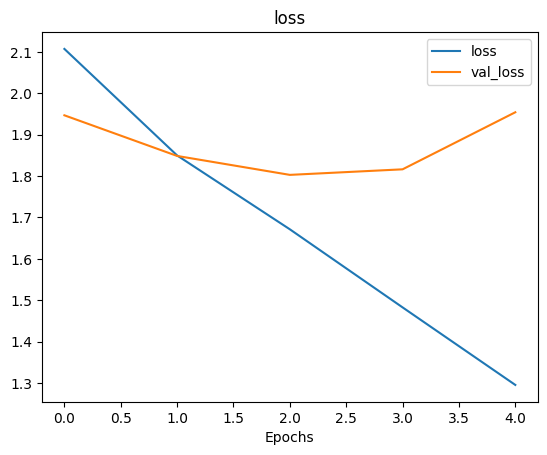

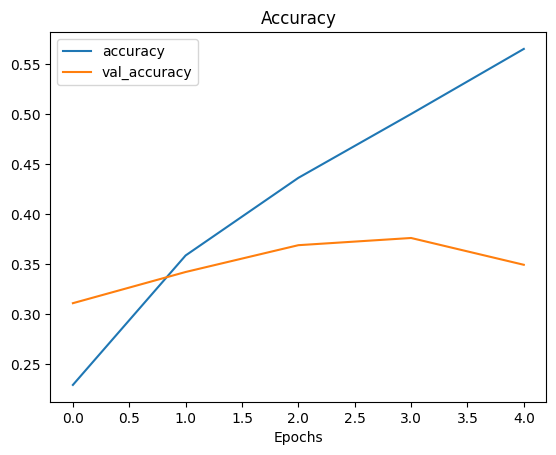

In [60]:
plot_loss_curve(history_8.history)

Looking at the curve , it seems the model is **overfitting** the training set quite badly.In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on unseen data.

### Ways to improve the model
* Get more data
* Simplify the model
* Use data augmentation
* Use transfer learning

🔑note: Preventing overfitting is also referred to as regularization

Let's try with **data augmentation** as first attempt to prevent our model from overfitting. Data Augmentation makes it harder for the model to learn on the training data and in turn, hopefully will make patterns it learns more generic in order to perform on generalized data.

In [61]:
# Create augmented data
train_datagen_augmented = ImageDataGenerator(rescale=1/255.
                                             ,rotation_range=20
                                             ,width_shift_range=0.2
                                             ,height_shift_range=0.2
                                             ,zoom_range=0.2
                                             ,horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir
                                                                   ,target_size=(224,224)
                                                                   ,class_mode="categorical"
                                                                   ,batch_size=32
                                                                   ,shuffle=True)


Found 7500 images belonging to 10 classes.


In [62]:
# Re-use the model architecture
model_9 = tf.keras.models.clone_model(model_8)

# Compile the model
model_9.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_9 = model_9.fit(train_data_augmented
                        ,steps_per_epoch=len(train_data_augmented)
                        ,validation_data=test_data
                        ,validation_steps=len(test_data)
                        ,epochs=5)

Epoch 1/5
235/235 [==============================] - 128s 537ms/step - loss: 2.1555 - accuracy: 0.2185 - val_loss: 1.9939 - val_accuracy: 0.3044
Epoch 2/5
235/235 [==============================] - 126s 537ms/step - loss: 2.0600 - accuracy: 0.2680 - val_loss: 1.9320 - val_accuracy: 0.3332
Epoch 3/5
235/235 [==============================] - 125s 532ms/step - loss: 2.0178 - accuracy: 0.2849 - val_loss: 1.9457 - val_accuracy: 0.3068
Epoch 4/5
235/235 [==============================] - 134s 573ms/step - loss: 1.9804 - accuracy: 0.3029 - val_loss: 1.8528 - val_accuracy: 0.3616
Epoch 5/5
235/235 [==============================] - 125s 532ms/step - loss: 1.9485 - accuracy: 0.3212 - val_loss: 1.7997 - val_accuracy: 0.3772


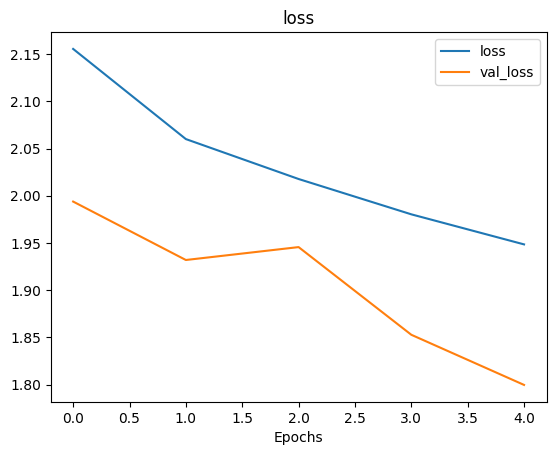

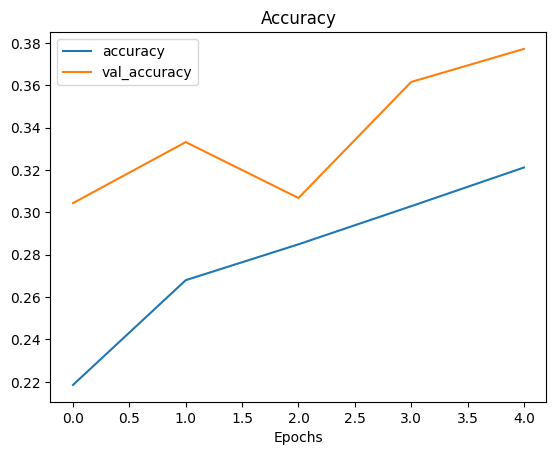

In [63]:
plot_loss_curve(history_9.history)

In [64]:
train_dir,test_dir

('10_food_classes_all_data/train/', '10_food_classes_all_data/test/')

In [65]:

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir
                                                            ,labels="inferred"
                                                            ,label_mode="categorical"
                                                            ,image_size=(224,224)
                                                            ,shuffle=True
                                                            ,batch_size=32)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir
                                                           ,labels="inferred"
                                                           ,label_mode="categorical"
                                                           ,image_size=(224,224)
                                                           ,shuffle=True
                                                           ,batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [66]:
model_10 = tf.keras.models.clone_model(model_8)

# compile
model_10.compile(loss=tf.keras.losses.categorical_crossentropy
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["accuracy"]
                 )

# fit the model
history_10 = model_10.fit(train_dataset
                          ,steps_per_epoch=len(train_dataset)
                          ,validation_data=test_dataset
                          ,validation_steps=len(test_dataset)
                          ,epochs=5
                          )

Epoch 1/5
235/235 [==============================] - 23s 89ms/step - loss: 3.2330 - accuracy: 0.1065 - val_loss: 2.3071 - val_accuracy: 0.1064
Epoch 2/5
235/235 [==============================] - 22s 90ms/step - loss: 2.2669 - accuracy: 0.1380 - val_loss: 2.3166 - val_accuracy: 0.1200
Epoch 3/5
235/235 [==============================] - 22s 91ms/step - loss: 2.1534 - accuracy: 0.1940 - val_loss: 2.3612 - val_accuracy: 0.1336
Epoch 4/5
235/235 [==============================] - 22s 91ms/step - loss: 1.9829 - accuracy: 0.2793 - val_loss: 2.4707 - val_accuracy: 0.1408
Epoch 5/5
235/235 [==============================] - 22s 89ms/step - loss: 1.7524 - accuracy: 0.3665 - val_loss: 2.8130 - val_accuracy: 0.1524


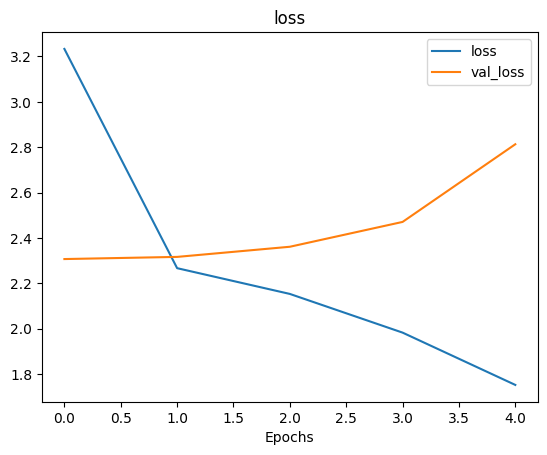

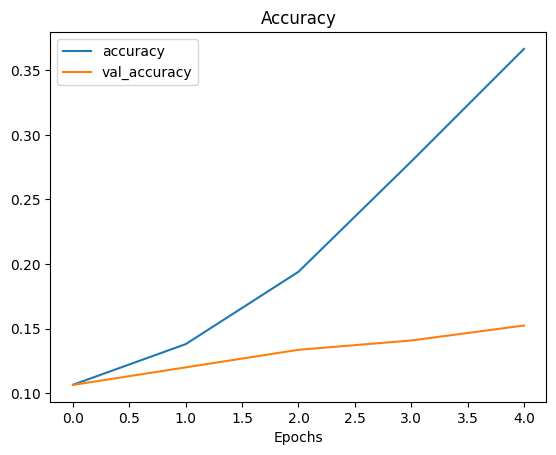

In [67]:
plot_loss_curve(history_10.history)

In [68]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


model_11 = Sequential([
    layers.Rescaling(scale=1./255,input_shape=(224,224,3))
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D(pool_size=2)
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D()
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D()
    ,layers.Flatten()
    ,layers.Dense(10,activation="softmax")
])
# compile the model
model_11.compile(loss=tf.keras.losses.categorical_crossentropy
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["accuracy"]
                 )

# fit the model
history_11 = model_11.fit(train_dataset
              ,steps_per_epoch=len(train_dataset)
              ,validation_data=test_dataset
              ,validation_steps=len(test_dataset)
              ,epochs=5
                          )

Epoch 1/5
235/235 [==============================] - 26s 42ms/step - loss: 2.0992 - accuracy: 0.2420 - val_loss: 1.9797 - val_accuracy: 0.2936
Epoch 2/5
235/235 [==============================] - 5s 22ms/step - loss: 1.8616 - accuracy: 0.3619 - val_loss: 1.8954 - val_accuracy: 0.3332
Epoch 3/5
235/235 [==============================] - 5s 22ms/step - loss: 1.6552 - accuracy: 0.4392 - val_loss: 1.8871 - val_accuracy: 0.3592
Epoch 4/5
235/235 [==============================] - 5s 22ms/step - loss: 1.4096 - accuracy: 0.5293 - val_loss: 1.9191 - val_accuracy: 0.3444
Epoch 5/5
235/235 [==============================] - 5s 23ms/step - loss: 1.1676 - accuracy: 0.6112 - val_loss: 2.1671 - val_accuracy: 0.3324


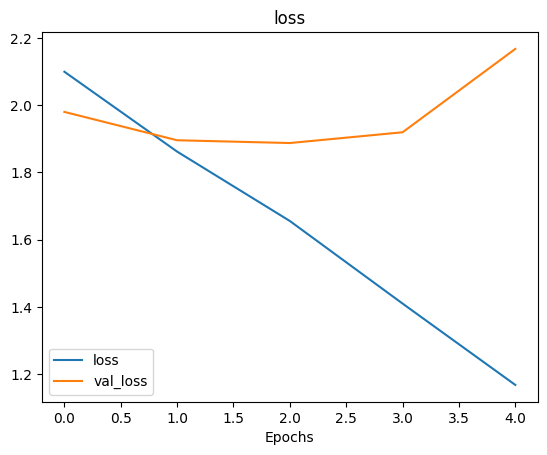

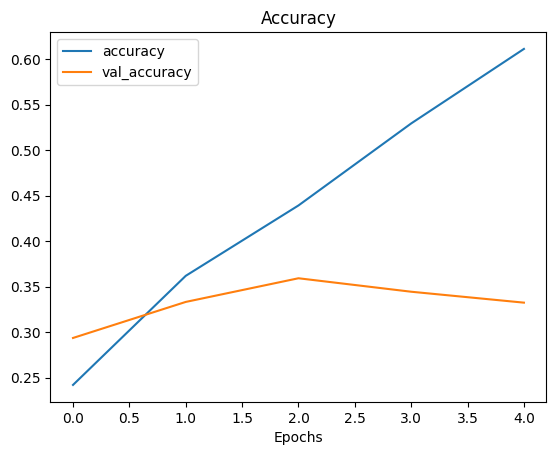

In [70]:
plot_loss_curve(history_11.history)

As evident from loss curve graph the model is overfitting. Let's try data augmentation and retrain the model as **data augmentation** will make it harder for the model to train on training data and hence will be able to learn the pattern in more generic way to perform better on unseen data

In [71]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal",input_shape=(224,224,3))
    ,layers.RandomRotation(0.1)
    ,layers.RandomZoom(0.1)
])

In [72]:
tf.random.set_seed(42)

model_12 = Sequential([
    data_augmentation
    ,layers.Rescaling(scale=1./255,input_shape=(224,224,3))
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D(pool_size=2)
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D()
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D()
    ,layers.Flatten()
    ,layers.Dense(10,activation="sigmoid")
  ])

model_12.compile(loss= tf.keras.losses.categorical_crossentropy
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["accuracy"]
                 )

history_12 = model_12.fit(train_dataset
                          ,steps_per_epoch=len(train_dataset)
                          ,validation_data=test_dataset
                          ,validation_steps=len(test_dataset)
                          ,epochs=5
                          )

Epoch 1/5
235/235 [==============================] - 8s 26ms/step - loss: 2.1331 - accuracy: 0.2247 - val_loss: 2.0023 - val_accuracy: 0.2800
Epoch 2/5
235/235 [==============================] - 6s 24ms/step - loss: 1.9731 - accuracy: 0.3059 - val_loss: 1.8698 - val_accuracy: 0.3308
Epoch 3/5
235/235 [==============================] - 6s 26ms/step - loss: 1.9086 - accuracy: 0.3369 - val_loss: 1.8587 - val_accuracy: 0.3536
Epoch 4/5
235/235 [==============================] - 6s 24ms/step - loss: 1.8785 - accuracy: 0.3475 - val_loss: 1.8126 - val_accuracy: 0.3696
Epoch 5/5
235/235 [==============================] - 6s 25ms/step - loss: 1.8455 - accuracy: 0.3673 - val_loss: 1.7822 - val_accuracy: 0.3896


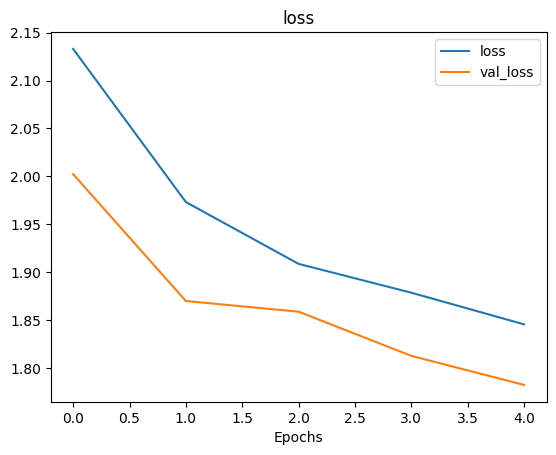

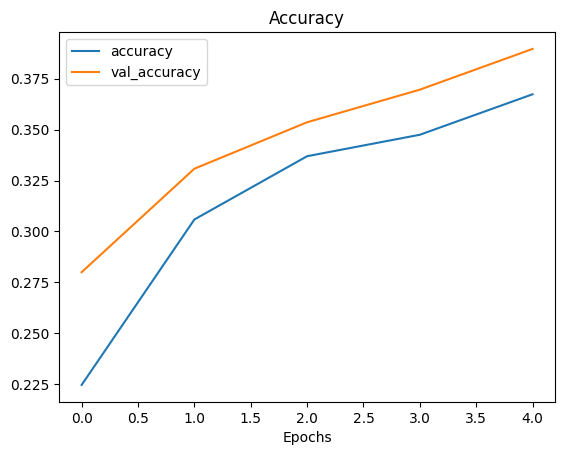

In [73]:
plot_loss_curve(history_12.history)

In [74]:
model_12.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                

In [75]:
def pred_and_plot(model,filename,class_names):
  """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with predicted class as the title
  """

  #import the image and preprocess it
  img = load_and_prep_image(filename)

  # Make prediction
  pred = model.predict(tf.expand_dims(img,axis=0))
  print(f" Prediction Prob: {pred}")
  # Get the predicted class
  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred[0][0]))]

  # Plot the image
  plt.imshow(img)
  plt.title(f" Prediction: {pred_class}")
  plt.axis(False);



In [76]:
classnames,classnames_10

(['pizza', 'steak'],
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

1/1 [==============================] - 0s 69ms/step
 Prediction Prob: [[0.10377847 0.360512   0.05355908 0.34399572 0.4288354  0.33266738
  0.02277575 0.44758818 0.8300265  0.3373558 ]]


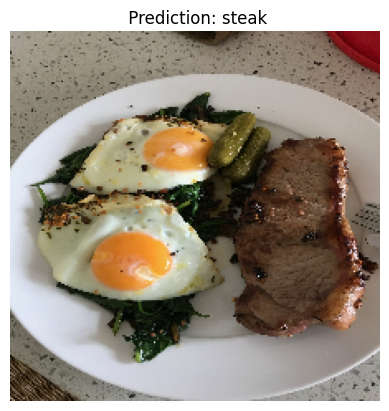

In [77]:
pred_and_plot(model_12,"/content/03-steak.jpeg",classnames_10)

In [78]:
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg

1/1 [==============================] - 0s 19ms/step
 Prediction Prob: [[0.1038075  0.36106932 0.05337796 0.34435415 0.42846003 0.33275056
  0.02280509 0.4478943  0.83033    0.33707085]]


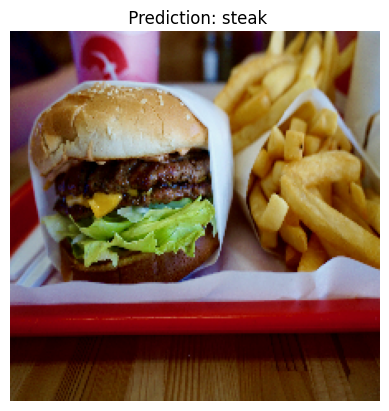

In [79]:
pred_and_plot(model_12,"/content/03-hamburger.jpeg",classnames_10)

1/1 [==============================] - 0s 23ms/step
 Prediction Prob: [[0.10418794 0.3636604  0.05335578 0.34385315 0.42957333 0.3326817
  0.02287733 0.44658124 0.83072674 0.3365034 ]]


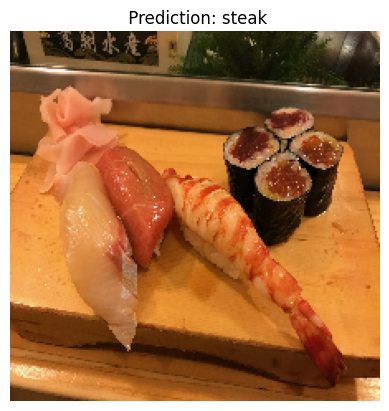

In [80]:
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
pred_and_plot(model_12,"/content/03-sushi.jpeg",classnames_10)

1/1 [==============================] - 0s 25ms/step
 Prediction Prob: [[0.10418794 0.3636604  0.05335578 0.34385315 0.42957333 0.3326817
  0.02287733 0.44658124 0.83072674 0.3365034 ]]


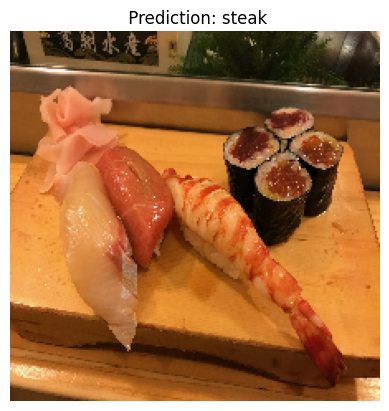

In [81]:
pred_and_plot(model_12,"/content/03-sushi.jpeg",classnames_10)

# ONNX Runtime with TensorFlow

In [82]:
!pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 42.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26


### Converting a Model

In [83]:
import tensorflow as tf
import tf2onnx
import onnx

onnx_model, _ = tf2onnx.convert.from_keras(model_12,input_signature=[1,224,224,3],opset=13)
onnx.save(onnx_model,"model_12_onnx")

TypeError: ignored